In [141]:
import argparse
import torch
import json
import yaml
import os
import sys
import random
import numpy as np
import torch.nn as nn
from tqdm import tqdm



/home


In [ ]:
current_folder = os.getcwd()
root_dir = os.path.dirname(current_folder)
sys.path.append(root_dir+'/implementation')
sys.path.append(root_dir)

In [ ]:
from implementation.data_loader.physio_dataloader import get_dataloader_physio, get_physio_dataloader_for_classification
from implementation.model.main_model import TSDE_Physio
from implementation.utils.utils import train, evaluate, gsutil_cp, set_seed, finetune, evaluate_finetuning, wait_for_file

In [142]:
device='cpu'
batch_size = 16
nsample = 100
run = 14
testmissingratio = 0.1

In [143]:
path = root_dir+"/implementation/config/" + 'base.yaml'
with open(path, "r") as f:
    config = yaml.safe_load(f)

In [144]:
foldername = root_dir+"/save/Clustering/" + 'PhysioNet' + "/n_samples_" + str(nsample) + "_run_" + str(run) + '_missing_ratio_' + str(testmissingratio) +"/"
model_checkpoint_dir = root_dir+"/save/Imputation-Classification/PhysioNet"+"/n_samples_" + str(nsample) + "_run_" + str(run) + '_missing_ratio_' + str(testmissingratio) +"/"
model = TSDE_Physio(config, device).to(device)
model.load_state_dict(torch.load(model_checkpoint_dir + "Pretrained/model.pth"))

train_loader_classification, valid_loader_classification, test_loader_classification = get_physio_dataloader_for_classification(filename=model_checkpoint_dir+'Pretrained/', batch_size=batch_size)


# Embedding of imputed MTS

In [145]:
def process_loader(loader, model, embeddings, labels):
    with tqdm(loader, mininterval=5.0, maxinterval=50.0) as it:
            for batch_no, batch in enumerate(it, start=1):
                (
                    observed_data,
                    observed_mask,
                    feature_id,
                    observed_tp,
                    gt_mask,
                    _,
                    _,
                    _,
                    classes
                ) = model.process_data(batch, sample_feat=model.sample_feat, train=False)
        
                x_co = (observed_mask * observed_data).unsqueeze(1)    
                mts_emb = model.get_mts_emb(observed_tp, observed_mask, x_co, feature_id)
                embeddings.append(mts_emb.cpu())
                labels.append(classes.cpu())

def get_embeddings(train_loader, valid_loader, test_loader, model):
    with torch.no_grad():
        model.eval()
        # Initialize lists to store embeddings
        train_embeddings = []
        valid_embeddings = []
        test_embeddings = []
        
        train_labels = []
        valid_labels = []
        test_labels = []
        
        # Process each data loader
        process_loader(train_loader, model, train_embeddings, train_labels)
        process_loader(valid_loader, model, valid_embeddings, valid_labels)
        process_loader(test_loader, model, test_embeddings, test_labels)
        
        # Concatenate all embeddings into tensors
        train_embeddings_tensor = torch.cat(train_embeddings, dim=0)
        valid_embeddings_tensor = torch.cat(valid_embeddings, dim=0)
        test_embeddings_tensor = torch.cat(test_embeddings, dim=0)
        
        train_labels = torch.cat(train_labels, dim=0)
        valid_labels = torch.cat(valid_labels, dim=0)
        test_labels= torch.cat(test_labels, dim=0)

        return train_embeddings_tensor, valid_embeddings_tensor, test_embeddings_tensor, train_labels, valid_labels, test_labels
                
                
        

In [146]:
train_embeddings_tensor, valid_embeddings_tensor, test_embeddings_tensor, train_labels, valid_labels, test_labels = get_embeddings(train_loader_classification, valid_loader_classification, test_loader_classification, model)

100%|██████████| 50/50 [02:44<00:00,  3.29s/it]


# Clustering

In [147]:
B_train, C, K, L = train_embeddings_tensor.shape
B_valid = valid_embeddings_tensor.shape[0]
B_test = test_embeddings_tensor.shape[0]

In [148]:
X = torch.concat((train_embeddings_tensor, valid_embeddings_tensor, test_embeddings_tensor), dim=0).reshape(B_train+B_valid+B_test, C*K*L)
true_labels = torch.concat((train_labels, valid_labels, test_labels), dim=0) 

In [149]:
count_1s = torch.sum(true_labels).item()
count_0s = torch.numel(true_labels) - count_1s
print('Total number of positive classes', count_1s)
print('Total number of negative classes', count_0s)

Total number of positive classes 554
Total number of negative classes 3443


## Using UMAP

In [150]:
X = test_embeddings_tensor.reshape(B_test, C*K*L)
true_labels = test_labels

In [151]:
# Assuming positive label is 1 and negative label is 0
positive = X[true_labels == 1]
negative = X[true_labels == 0]


# Downsample the negative class
negative_downsampled = negative[torch.randperm(negative.size(0))[:100]]
positive_downsampled = positive[torch.randperm(positive.size(0))[:100]]

# Combine the downsampled negative class with the positive class
balanced_embeddings = torch.cat([positive_downsampled, negative_downsampled], dim=0)
balanced_labels = torch.cat([torch.ones(100), torch.zeros(100)])


In [162]:
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


reducer = umap.UMAP(
    n_neighbors=7,
    min_dist=0,
    n_components=2,
    metric="jaccard",
    random_state=42,
)

embedding = reducer.fit_transform(balanced_embeddings[:,:-35*48])
embedding.shape


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(200, 2)

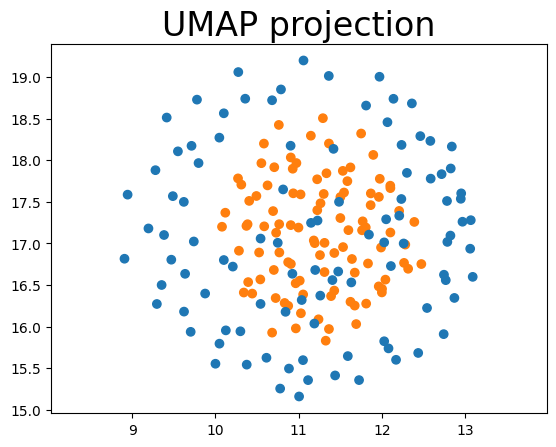

In [163]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[int(x.item())] for x in balanced_labels])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24);

In [164]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.5, min_samples=20).fit(embedding)

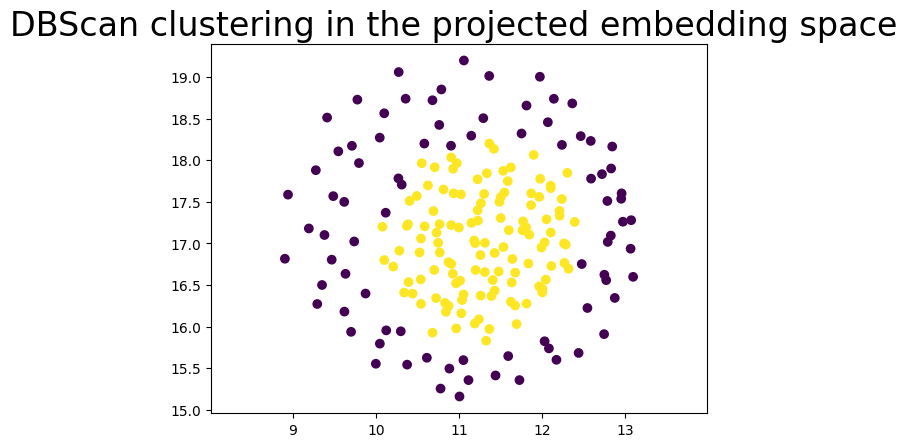

In [165]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=clustering.labels_)
plt.gca().set_aspect('equal', 'datalim')
plt.title('DBScan clustering in the projected embedding space ', fontsize=24);

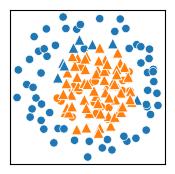

In [410]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# shuffle lists
indices = list(range(len(clustering.labels_)))
random.shuffle(indices)

data = {
    'x': [embedding[:, 0][i] for i in indices][:150],
    'y': [embedding[:, 1][i] for i in indices][:150],
    'class': [list(balanced_labels.numpy())[i] for i in indices][:150],  # Categorical feature for class
    'cluster': [(clustering.labels_ + 1)[i] for i in indices][:150]   # Categorical feature for cluster
}
df = pd.DataFrame(data)

# Set the plot size
plt.figure(figsize=(2, 2))  # Size in inches, e.g., 10 inches by 10 inches

# Create scatter plot for cluster 0 with circle markers
sns.scatterplot(data=df[df['class'] == 0], x='x', y='y', hue='cluster', style='class', markers={0: "o", 1: "^"}, legend=False)

# Create scatter plot for cluster 1 with larger triangle markers
sns.scatterplot(data=df[df['class'] == 1], x='x', y='y', hue='cluster', style='class', markers={0: "o", 1: "^"}, s=60, legend=False)  # Increase size with s=100

# Remove x and y-axis labels
plt.xlabel('')
plt.ylabel('')

# Remove x and y-axis ticks
plt.xticks([])
plt.yticks([])

# Save the plot to a PDF file
plt.savefig("cluster-imputed-embed.pdf", format='pdf')

# Show the plot
plt.show()

# Using raw MTS

In [233]:
train_loader, valid_loader, test_loader = get_dataloader_physio(nfold=0)

In [272]:
def process_loader_get_raw_mts(loader, model, mts, labels):
    with tqdm(loader, mininterval=5.0, maxinterval=50.0) as it:
            for batch_no, batch in enumerate(it, start=1):
                (
                    observed_data,
                    observed_mask,
                    feature_id,
                    observed_tp,
                    gt_mask,
                    _,
                    _,
                    _,
                    classes
                ) = model.process_data(batch, sample_feat=model.sample_feat, train=False)
                mts.append(observed_data.cpu())
                labels.append(classes.cpu())

def get_mts(train_loader, valid_loader, test_loader, model):
    with torch.no_grad():
        model.eval()
        # Initialize lists to store embeddings
        train_mts = []
        valid_mts = []
        test_mts = []
        
        train_labels = []
        valid_labels = []
        test_labels = []
        
        # Process each data loader
        process_loader_get_raw_mts(train_loader, model, train_mts, train_labels)
        process_loader_get_raw_mts(valid_loader, model, valid_mts, valid_labels)
        process_loader_get_raw_mts(test_loader, model, test_mts, test_labels)
        
        # Concatenate all embeddings into tensors
        train_tensor = torch.cat(train_mts, dim=0)
        valid_tensor = torch.cat(valid_mts, dim=0)
        test_tensor = torch.cat(test_mts, dim=0)
        
        train_labels = torch.cat(train_labels, dim=0)
        valid_labels = torch.cat(valid_labels, dim=0)
        test_labels= torch.cat(test_labels, dim=0)

        return train_tensor, valid_tensor, test_tensor, train_labels, valid_labels, test_labels

In [273]:
train_tensor, valid_tensor, test_tensor, train_labels, valid_labels, test_labels = get_mts(train_loader, valid_loader, test_loader, model)

100%|██████████| 50/50 [00:00<00:00, 2106.89it/s]


In [274]:
mts_all = test_tensor.reshape(B_test, K*L)

In [275]:
# Assuming positive label is 1 and negative label is 0
mts_positive = mts_all[true_labels == 1]
mts_negative = mts_all[true_labels == 0]


# Downsample the negative class
mts_negative_downsampled = mts_negative[torch.randperm(mts_negative.size(0))[:100]]
mts_positive_downsampled = mts_positive[torch.randperm(mts_positive.size(0))[:100]]

# Combine the downsampled negative class with the positive class
balanced_mts = torch.cat([mts_positive_downsampled, mts_negative_downsampled], dim=0)


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1879: UserWarning:

gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



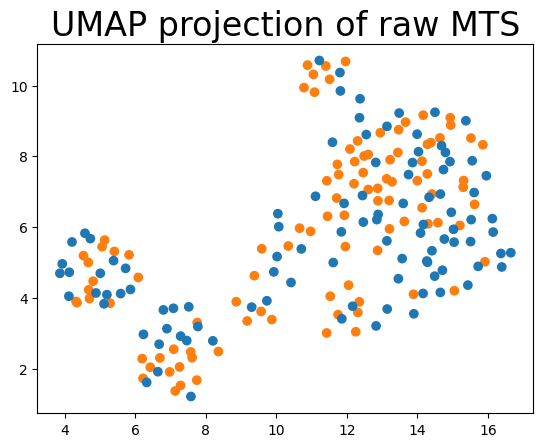

In [333]:
reducer_raw = umap.UMAP(
    n_neighbors=7,
    min_dist=0.6,
    n_components=2,
    metric="jaccard",
    random_state=42,
)

embedding_raw = reducer_raw.fit_transform(balanced_mts)

plt.scatter(
    embedding_raw[:, 0],
    embedding_raw[:, 1],
    c=[sns.color_palette()[int(x.item())] for x in balanced_labels])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of raw MTS', fontsize=24);

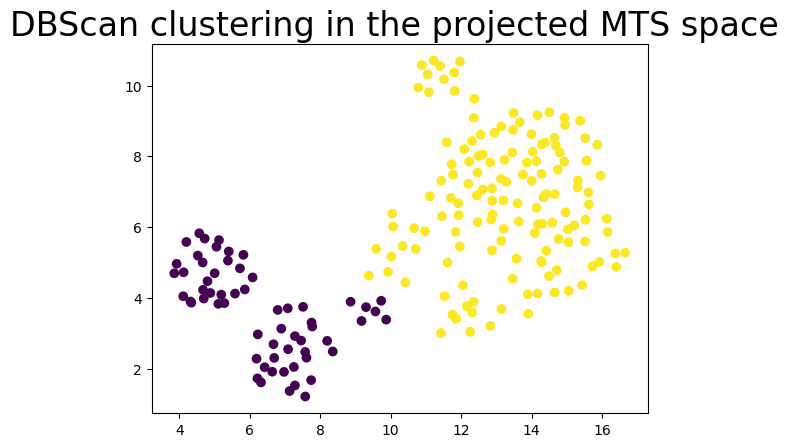

In [355]:
clustering_raw = DBSCAN(eps=1.917, min_samples=20).fit(embedding_raw)
plt.scatter(
    embedding_raw[:, 0],
    embedding_raw[:, 1],
    c=clustering_raw.labels_)
plt.gca().set_aspect('equal', 'datalim')
plt.title('DBScan clustering in the projected MTS space ', fontsize=24);

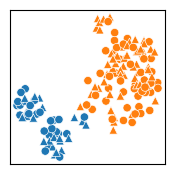

In [405]:
# shuffle lists
indices = list(range(len(clustering.labels_)))
random.shuffle(indices)

data = {
    'x': [embedding_raw[:, 0][i] for i in indices][:150],
    'y': [embedding_raw[:, 1][i] for i in indices][:150],
    'class': [list(balanced_labels.numpy())[i] for i in indices][:150],  # Categorical feature for class
    'cluster': [(clustering_raw.labels_)[i] for i in indices][:150]   # Categorical feature for cluster
}
df = pd.DataFrame(data)

# Define marker for each cluster
markers = {0: "o", 1: "^"}

# Set the plot size
plt.figure(figsize=(2, 2))  # Size in inches, e.g., 10 inches by 10 inches

# Create scatter plot without a legend
ax = sns.scatterplot(data=df, x='x', y='y', hue='cluster', style='class', markers=markers, legend=False)

# Remove x and y-axis labels
ax.set_xlabel('')
ax.set_ylabel('')

# Remove x and y-axis ticks
plt.xticks([])
plt.yticks([])

# Save the plot to a PDF file
plt.savefig("cluster-raw.pdf", format='pdf')

# Show the plot
plt.show()

# Embedding of Raw MTS

In [394]:
def process_loader_embedding_raw_mts(loader, model, embeddings, labels):
    with tqdm(loader, mininterval=5.0, maxinterval=50.0) as it:
            for batch_no, batch in enumerate(it, start=1):
                (
                    observed_data,
                    observed_mask,
                    feature_id,
                    observed_tp,
                    gt_mask,
                    _,
                    _,
                    _,
                    classes
                ) = model.process_data(batch, sample_feat=model.sample_feat, train=False)
        
                x_co = (observed_mask * observed_data).unsqueeze(1)    
                mts_emb = model.get_mts_emb(observed_tp, observed_mask, x_co, feature_id)
                embeddings.append(mts_emb.cpu())
                labels.append(classes.cpu())
                
                
def get_embeddings_raw_mts(train_loader, valid_loader, test_loader, model):
    with torch.no_grad():
        model.eval()
        # Initialize lists to store embeddings
        train_embeddings = []
        valid_embeddings = []
        test_embeddings = []
        
        train_labels = []
        valid_labels = []
        test_labels = []
        
        # Process each data loader
        process_loader_embedding_raw_mts(train_loader, model, train_embeddings, train_labels)
        process_loader_embedding_raw_mts(valid_loader, model, valid_embeddings, valid_labels)
        process_loader_embedding_raw_mts(test_loader, model, test_embeddings, test_labels)
        
        # Concatenate all embeddings into tensors
        train_embeddings_tensor = torch.cat(train_embeddings, dim=0)
        valid_embeddings_tensor = torch.cat(valid_embeddings, dim=0)
        test_embeddings_tensor = torch.cat(test_embeddings, dim=0)
        
        train_labels = torch.cat(train_labels, dim=0)
        valid_labels = torch.cat(valid_labels, dim=0)
        test_labels= torch.cat(test_labels, dim=0)

        return train_embeddings_tensor, valid_embeddings_tensor, test_embeddings_tensor, train_labels, valid_labels, test_labels


In [395]:
train_tensor_emb_raw, valid_tensor_emb_raw, test_tensor_emb_raw, train_labels, valid_labels, test_labels = get_embeddings_raw_mts(train_loader, valid_loader, test_loader, model)

100%|██████████| 50/50 [00:07<00:00,  6.35it/s]


In [396]:
X_emb_raw = test_tensor_emb_raw.reshape(B_test, C*K*L)

# Assuming positive label is 1 and negative label is 0
positive_emb_raw = X_emb_raw[true_labels == 1]
negative_emb_raw = X_emb_raw[true_labels == 0]


# Downsample the negative class
negative_downsampled_emb_raw = negative_emb_raw[torch.randperm(negative_emb_raw.size(0))[:100]]
positive_downsampled_emb_raw = positive_emb_raw[torch.randperm(positive_emb_raw.size(0))[:100]]

# Combine the downsampled negative class with the positive class
balanced_emb_raw = torch.cat([positive_downsampled_emb_raw, negative_downsampled_emb_raw], dim=0)


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1879: UserWarning:

gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



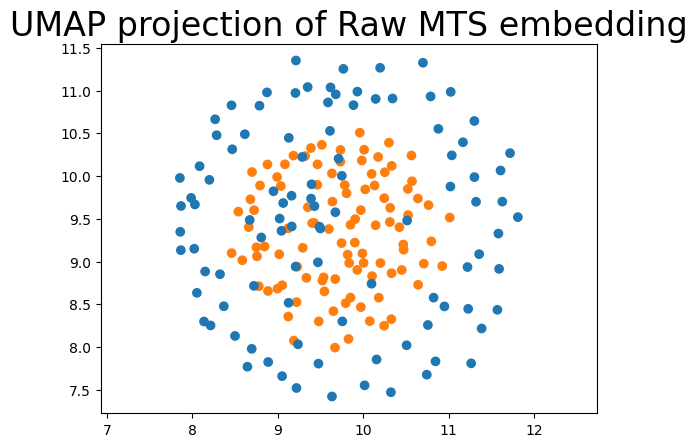

In [397]:
reducer_emb_raw = umap.UMAP(
    n_neighbors=7,
    min_dist=0,
    n_components=2,
    metric="jaccard",
    random_state=42,
)

embedding_emb_raw = reducer_emb_raw.fit_transform(balanced_emb_raw[:,:-35*48])

plt.scatter(
    embedding_emb_raw[:, 0],
    embedding_emb_raw[:, 1],
    c=[sns.color_palette()[int(x.item())] for x in balanced_labels])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of Raw MTS embedding', fontsize=24);

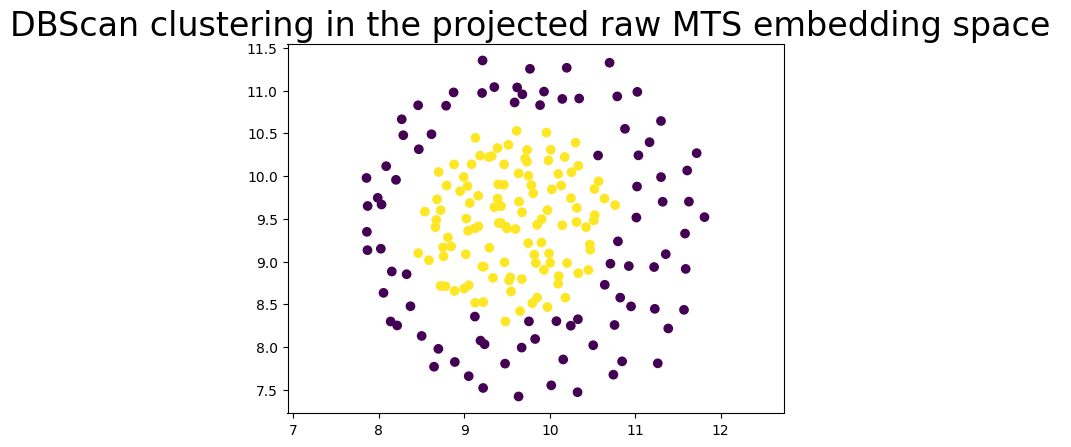

In [398]:
clustering_emb_raw = DBSCAN(eps=0.5, min_samples=20).fit(embedding_emb_raw)
plt.scatter(
    embedding_emb_raw[:, 0],
    embedding_emb_raw[:, 1],
    c=clustering_emb_raw.labels_)
plt.gca().set_aspect('equal', 'datalim')
plt.title('DBScan clustering in the projected raw MTS embedding space ', fontsize=24);

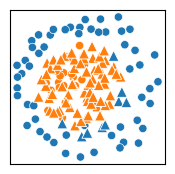

In [403]:
# shuffle lists
indices = list(range(len(clustering.labels_)))
random.shuffle(indices)

data = {
    'x': [embedding_emb_raw[:, 0][i] for i in indices][:150],
    'y': [embedding_emb_raw[:, 1][i] for i in indices][:150],
    'class': [list(balanced_labels.numpy())[i] for i in indices][:150],  # Categorical feature for class
    'cluster': [(clustering_emb_raw.labels_ + 1)[i] for i in indices][:150]   # Categorical feature for cluster
}
df = pd.DataFrame(data)

# Set the plot size
plt.figure(figsize=(2, 2))  # Size in inches, e.g., 10 inches by 10 inches

# Create scatter plot for cluster 0 with circle markers
sns.scatterplot(data=df[df['class'] == 0], x='x', y='y', hue='cluster', style='class', markers={0: "o", 1: "^"}, legend=False)

# Create scatter plot for cluster 1 with larger triangle markers
sns.scatterplot(data=df[df['class'] == 1], x='x', y='y', hue='cluster', style='class', markers={0: "o", 1: "^"}, s=60, legend=False)  # Increase size with s=100

# Remove x and y-axis labels
plt.xlabel('')
plt.ylabel('')

# Remove x and y-axis ticks
plt.xticks([])
plt.yticks([])

# Save the plot to a PDF file
plt.savefig("cluster-imputed-raw.pdf", format='pdf')

# Show the plot
plt.show()

In [139]:
from sklearn.metrics import rand_score, adjusted_mutual_info_score

print(f"Rand Index (clustering of Raw MTS):", rand_score(balanced_labels, clustering_raw.labels_))
print(f"Rand Index (clustering of Raw MTS embedding):", rand_score(balanced_labels, clustering_emb_raw.labels_))
print(f"Rand Index (clustering of imputed MTS embeddings):", rand_score(balanced_labels, clustering.labels_))

Rand Index (clustering of Raw MTS): 0.5015577889447236
Rand Index (clustering of Raw MTS embedding): 0.7367336683417085
Rand Index (clustering of imputed MTS embeddings): 0.6844723618090452


In [140]:
print(f"Adjusted Rand Index (clustering of Raw MTS):", adjusted_mutual_info_score(balanced_labels, clustering_raw.labels_))
print(f"Adjusted Rand Index (clustering of Raw MTS embedding):", adjusted_mutual_info_score(balanced_labels, clustering_emb_raw.labels_))
print(f"Adjusted Rand Index (clustering of imputed MTS embeddings):", adjusted_mutual_info_score(balanced_labels, clustering.labels_))

Adjusted Rand Index (clustering of Raw MTS): 0.010414125303701265
Adjusted Rand Index (clustering of Raw MTS embedding): 0.4257262906601621
Adjusted Rand Index (clustering of imputed MTS embeddings): 0.30199389317232694
